### Forecasting a Time Series

In [ ]:
import tensorflow as tf
import pandas as pd
from pathlib import Path 


2025-03-14 15:57:10.117507: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 15:57:10.248465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741947130.310520     381 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741947130.324554     381 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 15:57:10.461736: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
path = Path('datasets/CTA_-_Ridership_-_Daily_Boarding_Totals.csv')
df = pd.read_csv(path,parse_dates=['service_date'])


In [4]:
df.head()

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343


In [5]:
df.columns = ['date','day_type','bus','train','total']
df = df.sort_values('date').set_index('date')

In [6]:
df.head()

,day_type,bus,train,total
date,,,,
2001-01-01,U,297192,126455,423647
2001-01-02,W,780827,501952,1282779
2001-01-03,W,824923,536432,1361355
2001-01-04,W,870021,550011,1420032
2001-01-05,W,890426,557917,1448343


In [7]:
df.drop('total',axis = 'columns',inplace = True)#no need for total , its just bus+ rail
df.drop_duplicates() #remove duplicated months (2022-10 and 2014-07)

,day_type,bus,train
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2021-11-26,W,257700,189694
2021-11-27,A,237839,187065
2021-11-28,U,184817,147830


In [8]:
df.tail()

,day_type,bus,train
date,,,
2021-11-26,W,257700,189694
2021-11-27,A,237839,187065
2021-11-28,U,184817,147830
2021-11-29,W,421322,276090
2021-11-30,W,450230,302349


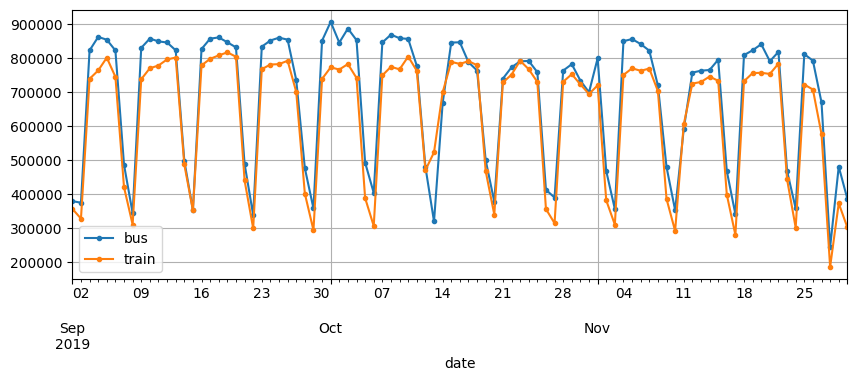

In [9]:
import matplotlib.pyplot as plt

df['2019-09':'2019-11'].plot(grid=True,marker = '.',figsize = (10,3.5))
plt.show()

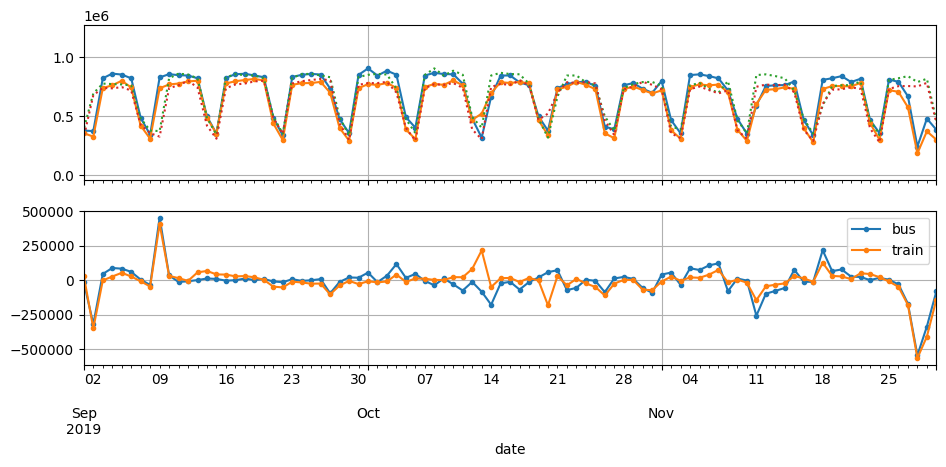

In [10]:
diff_7 = df[['bus','train']].diff(7)['2019-09':'2019-11']

fig,axs = plt.subplots(2,1,sharex=True,figsize=(11,5))
df.plot(ax=axs[0],legend = False,marker='.')#original time series


df.shift(7).plot(ax=axs[0],grid=True,legend=False,linestyle=':') #lagged on the top
diff_7.plot(ax=axs[1],grid=True,marker='.') #7-day difference time series
plt.show()

In [11]:
list (df.loc['2019-11-24':'2019-11-27']['day_type'])

['U', 'W', 'W', 'W']

In [12]:
diff_7.abs().mean()

bus      61545.692308
train    55122.241758
dtype: float64

In [13]:
targets = df[['bus','train']]['2019-09':'2019-11']

(diff_7/targets).abs().mean()


bus      0.113952
train    0.131061
dtype: float64

In [14]:
period = df['2001-01-01':'2019-11-28']
period.tail()

,day_type,bus,train
date,,,
2019-11-24,U,358133,301849
2019-11-25,W,810928,721624
2019-11-26,W,791651,707015
2019-11-27,W,669245,576379
2019-11-28,U,244233,186732


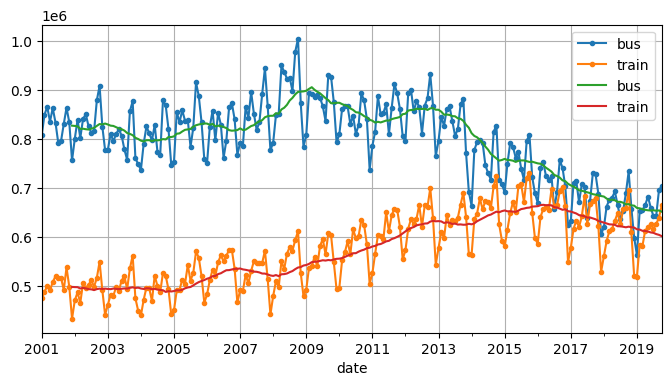

In [15]:
# Define the start and end dates for the period
start_date = '2001-01-01'
end_date = '2019-11-22'

# Select only numeric columns for resampling and mean calculation
df_numeric = df.select_dtypes(include='number')

# Resample the data to monthly frequency and compute the mean
df_monthly = df_numeric.resample('ME').mean()

# Filter the data for the specified period using .loc[]
df_monthly_period = df_monthly.loc[start_date:end_date]

# Compute the 12-month rolling average
rolling_average_12_months = df_monthly_period.rolling(window=12).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly_period.plot(ax=ax, marker='.', label='Monthly Mean')
rolling_average_12_months.plot(ax=ax, grid=True, label='12-Month Rolling Mean', legend=True)

plt.legend()
plt.show() 

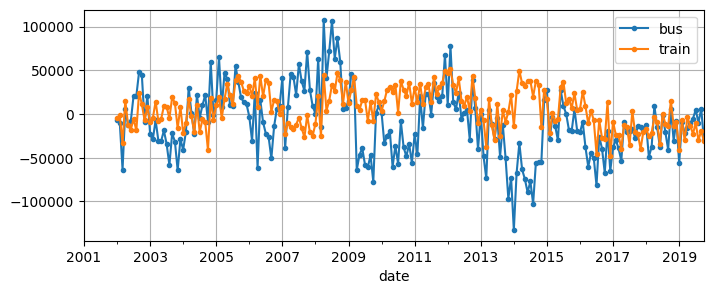

In [16]:
df_monthly.diff(12)[start_date:end_date].plot(grid=True,marker='.',figsize =(8,3))
plt.show()

### The ARMA Model Family

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
origin , today = '2019-01-01','2019-05-31'
train_series = df.loc[origin:today]['train'].asfreq('D')
model = ARIMA(train_series,
              order = (1,0,0),
              seasonal_order = (0,1,1,7))
model = model.fit()
y_pred = model.forecast()
print(y_pred)

2019-06-01    427758.626288
Freq: D, dtype: float64


In [19]:
origin,start_date,end_date = '2019-01-01','2019-03-01','2019-05-28'
time_period = pd.date_range(start_date,end_date)
train_series = df.loc[origin:today]['train'].asfreq('D')
y_preds= []

for today in time_period.shift(-1):
    model = ARIMA(train_series[origin:today], #train on data up to 'today'
                  order = (1,0,0),
                  seasonal_order=(0,1,1,7))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds,index=time_period)
mae = (y_preds - train_series[time_period]).abs().mean()
print(mae)

/tmp/ipykernel_381/697388269.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_381/697388269.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_381/697388269.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_381/697388269.py:11: FutureWarning: Series.__getitem__ treating keys as positions is dep

32538.497695629816


/tmp/ipykernel_381/697388269.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_381/697388269.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]


### Preparing the Data for Machinde Learning Models

In [20]:
my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(my_series,
                                                          targets=my_series[3:],
                                                          sequence_length=3,
                                                          batch_size=4)

2025-03-14 15:57:22.843846: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
list(my_dataset)

2025-03-14 15:57:23.051667: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3],
         [2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 4, 5], dtype=int32)>)]

In [22]:
for window_dataset in tf.data.Dataset.range(6).window(4,shift =1):
    for element in window_dataset:
        print(f'{element}',end = " ")
    print()

2025-03-14 15:57:23.078118: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-03-14 15:57:23.084437: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-14 15:57:23.090579: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-14 15:57:23.095950: W tensorflow/core/data/root_dataset.cc:362] Optimization loop failed: CANCELLED: Operation was cancelled


0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2025-03-14 15:57:23.101381: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
dataset = tf.data.Dataset.range(6).window(4,shift =1,drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset:window_dataset.batch(4))
for window_tensor in dataset:
    print(f'{window_tensor}')


[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [24]:
def to_windows(dataset,length):
    dataset = dataset.window(length,shift=1,drop_remainder=True)
    return dataset.flat_map(lambda window_ds:window_ds.batch(length))

In [25]:
#splitint the dataset usint map method
dataset = to_windows(tf.data.Dataset.range(6),4) # 3 inputs + 1 targe = 4
dataset = dataset.map(lambda window:(window[:-1],window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [26]:
### splitting the original dataset the ridership one
train_train = df['train']['2016-01':'2018-12'] / 1e6
train_val = df['train']['2019-01':'2019-05'] /1e6
train_test = df['train']["2019-06":]/1e6

In [1]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train_train.to_numpy(),
    targets = train_train[seq_length:],
    sequence_length = seq_length,
    batch_size = 32,
    shuffle = True,
    seed = 42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    train_val.to_numpy(),
    targets = train_val[seq_length:],
    sequence_length = seq_length,
    batch_size = 32
)
## And now we're ready to build and trian andy regression model we want!

NameError: name 'tf' is not defined

## Forecastin Using a Linear Model

In [28]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1,input_shape = [seq_length])

])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=['mae'])

history =  model.fit(train_ds,validation_data = valid_ds,epochs = 500,callbacks =[early_stopping_cb])


Epoch 1/500


/home/harry/Documents/Code/Data_Science/DeepLearning/.venv_tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6882 - mae: 1.1069 - val_loss: 0.0752 - val_mae: 0.3666
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316 - mae: 0.2083 - val_loss: 0.0093 - val_mae: 0.1038
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - mae: 0.0979 - val_loss: 0.0084 - val_mae: 0.0975
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - mae: 0.1019 - val_loss: 0.0069 - val_mae: 0.0905
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - mae: 0.0832 - val_loss: 0.0058 - val_mae: 0.0789
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - mae: 0.0797 - val_loss: 0.0057 - val_mae: 0.0734
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0730 - val_loss: 0.0051 - val_mae: 0.0698
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0736 - val_loss: 0.0049 - val_mae: 0.0690
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - mae: 0.0

## Now, Forecastin Using Simple RNN

In [29]:
model =  tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1,input_shape=[None,1])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=['mae'])

history =  model.fit(train_ds,validation_data = valid_ds,epochs = 500,callbacks =[early_stopping_cb])


/home/harry/Documents/Code/Data_Science/DeepLearning/.venv_tf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0250 - mae: 0.1683 - val_loss: 0.0184 - val_mae: 0.1429
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0173 - mae: 0.1606 - val_loss: 0.0176 - val_mae: 0.1503
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0171 - mae: 0.1616 - val_loss: 0.0176 - val_mae: 0.1459
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168 - mae: 0.1591 - val_loss: 0.0173 - val_mae: 0.1489
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0169 - mae: 0.1618 - val_loss: 0.0170 - val_mae: 0.1538
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0173 - mae: 0.1649 - val_loss: 0.0170 - val_mae: 0.1472
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0160 - mae: 0.1561 - val_loss: 0.0179 - val_mae: 0.1369
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - mae: 0.1523 - val_loss: 0.0167 - val_mae: 0.1502
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.01

In [30]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None,1]),
    tf.keras.layers.Dense(1)
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

univar_model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=['mae'])

history =  univar_model.fit(train_ds,validation_data = valid_ds,epochs = 500,callbacks =[early_stopping_cb])


Epoch 1/500


/home/harry/Documents/Code/Data_Science/DeepLearning/.venv_tf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0440 - mae: 0.2379 - val_loss: 0.0058 - val_mae: 0.0868
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mae: 0.0874 - val_loss: 0.0040 - val_mae: 0.0737
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mae: 0.0707 - val_loss: 0.0026 - val_mae: 0.0552
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mae: 0.0634 - val_loss: 0.0024 - val_mae: 0.0478
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mae: 0.0587 - val_loss: 0.0022 - val_mae: 0.0439
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mae: 0.0565 - val_loss: 0.0023 - val_mae: 0.0428
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mae: 0.0514 - val_loss: 0.0022 - val_mae: 0.0389
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mae: 0.0500 - val_loss: 0.0021 - val_mae: 0.0359
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mae: 0.

## Forecasting Using a Deep RNN

In [31]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

deep_model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=['mae'])

history =  deep_model.fit(train_ds,validation_data = valid_ds,epochs = 500,callbacks =[early_stopping_cb])


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1316 - mae: 0.3777 - val_loss: 0.0196 - val_mae: 0.1181
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0161 - mae: 0.1484 - val_loss: 0.0116 - val_mae: 0.1015
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0130 - mae: 0.1326 - val_loss: 0.0050 - val_mae: 0.0770
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0063 - mae: 0.0838 - val_loss: 0.0027 - val_mae: 0.0548
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0054 - mae: 0.0750 - val_loss: 0.0042 - val_mae: 0.0705
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0055 - mae: 0.0710 - val_loss: 0.0031 - val_mae: 0.0574
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0051 - mae: 0.0711 - val_loss: 0.0020 - val_mae: 0.0415
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0050 - mae: 0.0679 - val_loss: 0.0021 - val_mae: 0.0425
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - lo

## Forecasting Multivariate Time Series

In [32]:
df_mulvar= df[['bus','train']]/1e6  #use both bus & rail series as input
df_mulvar['next_day_type'] = df['day_type'].shift(-1)  #we know tomorrows's typye
one_hot = pd.get_dummies(df_mulvar['next_day_type']).astype('int64') #one-hot encode the day type
df_mulvar = pd.concat([df_mulvar,one_hot],axis = 1)
df_mulvar.drop(['next_day_type'],axis = 1,inplace=True)
df_mulvar.head()

,bus,train,A,U,W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


In [33]:
mulvar_train = df_mulvar['2016-01':'2019-12']
mulvar_valid = df_mulvar['2020-01':'2020-05']
mulvar_test = df_mulvar['2020-06':]

In [34]:
mulvar_test.shape,mulvar_train.shape,mulvar_valid.shape

((548, 5), (1461, 5), (152, 5))

In [35]:
#creating dataset
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(), #use all 5 columns as input
    targets = mulvar_train['train'][seq_length:],   #In  fact,  it’s  not  too  hard  to  make  the  RNN  forecast  both  the  bus  and  rail  rid‐ership.
                                                   # You  just  need  to  change  the  targets  when  creating  the  datasets,  setting them  to  
                                                   # mulvar_train[["bus",  "rail"]][seq_length:]  for  the  training  set,  and mulvar_valid[["bus",  "rail"]][seq_length:]  for  the  validation  set. 
                                                   # You  must Forecasting a Time Series  |  559
                                                   #also  add  an  extra  neuron  in  the  output  Dense  layer,  since  it  must  now  make  two
                                                   #forecasts: one for tomorrow’s bus ridership, and the other for rail. That’s all there is toit!

    sequence_length = seq_length,
    batch_size = 32,
    shuffle = True,
    seed = 42
    )

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets = mulvar_valid['train'][seq_length:],
    sequence_length = seq_length,
    batch_size = 32
    
)

In [36]:
#creating the model
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None,5]),
    tf.keras.layers.Dense(1)
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

mulvar_model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=['mae'])

history =  mulvar_model.fit(train_mulvar_ds,validation_data = valid_mulvar_ds,epochs = 500,callbacks =[early_stopping_cb])


Epoch 1/500


/home/harry/Documents/Code/Data_Science/DeepLearning/.venv_tf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0155 - mae: 0.1334 - val_loss: 0.0927 - val_mae: 0.3793
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mae: 0.0512 - val_loss: 0.0894 - val_mae: 0.3785
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mae: 0.0519 - val_loss: 0.0685 - val_mae: 0.3235
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mae: 0.0433 - val_loss: 0.0632 - val_mae: 0.3102
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mae: 0.0440 - val_loss: 0.0555 - val_mae: 0.2867
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mae: 0.0418 - val_loss: 0.0439 - val_mae: 0.2496
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mae: 0.0424 - val_loss: 0.0485 - val_mae: 0.2684
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0403 - val_loss: 0.0442 - val_mae: 0.2537
Epoch 9/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.

## Forecasting Seversl Time Steps Ahead

In [40]:
import numpy as np

X = train_val.to_numpy()[np.newaxis, : seq_length,np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X,y_pred_one.reshape(1,1,1)],axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


#### Forecastinf 14 steps ahead, 1 step at a time

In [41]:
def split_inputs_and_tarets(mulvar_series,ahead = 14,target_col=1):
    return mulvar_series[:,:-ahead],mulvar_series[:,-ahead:,target_col]


ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length = seq_length + 14,
    batch_size = 32,
    shuffle = True,
    seed = 42    
).map(split_inputs_and_tarets)


ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets = None,
    sequence_length = seq_length +14,
    batch_size = 32
).map(split_inputs_and_tarets)

In [42]:
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None,5]),
    tf.keras.layers.Dense(14)
])

/home/harry/Documents/Code/Data_Science/DeepLearning/.venv_tf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

ahead_model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=['mae'])

history =  ahead_model.fit(ahead_train_ds,validation_data= ahead_valid_ds,epochs = 500,callbacks =[early_stopping_cb])


Epoch 1/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1441 - mae: 0.4116 - val_loss: 0.1003 - val_mae: 0.3658
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0195 - mae: 0.1558 - val_loss: 0.0984 - val_mae: 0.3809
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - mae: 0.1353 - val_loss: 0.0948 - val_mae: 0.3750
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - mae: 0.1242 - val_loss: 0.0951 - val_mae: 0.3760
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - mae: 0.1139 - val_loss: 0.0934 - val_mae: 0.3706
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - mae: 0.1051 - val_loss: 0.0921 - val_mae: 0.3641
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - mae: 0.1001 - val_loss: 0.0920 - val_mae: 0.3627
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0080 - mae: 0.0945 - val_loss: 0.0928 - val_mae: 0.3620
Epoch 9/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [48]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
Y_pred = ahead_model.predict(X)
Y_pred 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.6674613 , 0.6564501 , 0.6427818 , 0.34408087, 0.26495183,
        0.6118857 , 0.67058176, 0.6708295 , 0.67061836, 0.62331307,
        0.34121555, 0.27643603, 0.6043147 , 0.67936677]], dtype=float32)

# Forecastin Using a Sequence to Sequence Model

In [50]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series,3),4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [51]:
dataset = dataset.map(lambda S: (S[:,0],S[:,1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

In [52]:
def to_seq2seq_dataset(series,seq_length=56,ahead = 14,target_col = 1,
                       batch_size = 32,
                       shuffle = False,
                       seed = None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series),ahead + 1)
    ds = to_windows(ds,seq_length).map(lambda S: (S[:,0],S[:,1:,1]))
    if shuffle:
        ds = ds.shuffle(8* batch_size ,seed = seed)
    return ds.batch(batch_size)

In [53]:
seq2seq_train = to_seq2seq_dataset(mulvar_train,shuffle=True,seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [54]:
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,return_sequences=True,input_shape=[None,5]),
    tf.keras.layers.Dense(14)
])

/home/harry/Documents/Code/Data_Science/DeepLearning/.venv_tf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)

seq2seq_model.compile(loss = tf.keras.losses.Huber(),optimizer=opt,metrics=['mae'])

history =  seq2seq_model.fit(seq2seq_train,validation_data= seq2seq_valid,epochs = 500,callbacks =[early_stopping_cb])


Epoch 1/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1829 - mae: 0.4653 - val_loss: 0.0768 - val_mae: 0.3160
Epoch 2/500


/home/harry/Documents/Code/Data_Science/DeepLearning/.venv_tf/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - mae: 0.1518 - val_loss: 0.0673 - val_mae: 0.2904
Epoch 3/500
14/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139 - mae: 0.1279

2025-03-14 16:36:28.584160: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0135 - mae: 0.1248 - val_loss: 0.0632 - val_mae: 0.2771
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - mae: 0.1108 - val_loss: 0.0612 - val_mae: 0.2690
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - mae: 0.1009 - val_loss: 0.0600 - val_mae: 0.2637
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - mae: 0.0939 - val_loss: 0.0588 - val_mae: 0.2586
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0080 - mae: 0.0890 - val_loss: 0.0589 - val_mae: 0.2578
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0849 - val_loss: 0.0580 - val_mae: 0.2544
Epoch 9/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071 - mae: 0.0821 - val_loss: 0.0573 - val_mae: 0.2522
Epoch 10/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0794 - val_loss: 0.0569 - val_mae: 0.2507
Epoch 11/500
17/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mae:

2025-03-14 16:36:32.454340: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - mae: 0.0781 - val_loss: 0.0564 - val_mae: 0.2491
Epoch 12/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0064 - mae: 0.0771 - val_loss: 0.0561 - val_mae: 0.2485
Epoch 13/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mae: 0.0754 - val_loss: 0.0555 - val_mae: 0.2467
Epoch 14/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mae: 0.0749 - val_loss: 0.0548 - val_mae: 0.2446
Epoch 15/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - mae: 0.0740 - val_loss: 0.0546 - val_mae: 0.2443
Epoch 16/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - mae: 0.0726 - val_loss: 0.0538 - val_mae: 0.2420
Epoch 17/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mae: 0.0724 - val_loss: 0.0538 - val_mae: 0.2426
Epoch 18/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0056 - mae: 0.0717 - val_loss: 0.0529 - val_mae: 0.2397
Epoch 19/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 

2025-03-14 16:36:40.099155: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mae: 0.0666 - val_loss: 0.0496 - val_mae: 0.2310
Epoch 28/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0669 - val_loss: 0.0496 - val_mae: 0.2313
Epoch 29/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0656 - val_loss: 0.0497 - val_mae: 0.2320
Epoch 30/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - mae: 0.0655 - val_loss: 0.0488 - val_mae: 0.2288
Epoch 31/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0653 - val_loss: 0.0487 - val_mae: 0.2289
Epoch 32/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0048 - mae: 0.0652 - val_loss: 0.0486 - val_mae: 0.2285
Epoch 33/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - mae: 0.0649 - val_loss: 0.0484 - val_mae: 0.2281
Epoch 34/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0047 - mae: 0.0640 - val_loss: 0.0483 - val_mae: 0.2281
Epoch 35/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.004

2025-03-14 16:36:59.193336: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mae: 0.0583 - val_loss: 0.0413 - val_mae: 0.2093
Epoch 60/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mae: 0.0584 - val_loss: 0.0409 - val_mae: 0.2079
Epoch 61/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0583 - val_loss: 0.0407 - val_mae: 0.2075
Epoch 62/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mae: 0.0580 - val_loss: 0.0403 - val_mae: 0.2063
Epoch 63/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0582 - val_loss: 0.0401 - val_mae: 0.2055
Epoch 64/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0579 - val_loss: 0.0400 - val_mae: 0.2058
Epoch 65/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mae: 0.0578 - val_loss: 0.0395 - val_mae: 0.2038
Epoch 66/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - mae: 0.0575 - val_loss: 0.0391 - val_mae: 0.2027
Epoch 67/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 -

2025-03-14 16:37:31.099089: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036 - mae: 0.0528 - val_loss: 0.0274 - val_mae: 0.1682
Epoch 124/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0517 - val_loss: 0.0271 - val_mae: 0.1671
Epoch 125/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0518 - val_loss: 0.0269 - val_mae: 0.1663
Epoch 126/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0518 - val_loss: 0.0268 - val_mae: 0.1661
Epoch 127/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - mae: 0.0522 - val_loss: 0.0267 - val_mae: 0.1658
Epoch 128/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0518 - val_loss: 0.0266 - val_mae: 0.1654
Epoch 129/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - mae: 0.0519 - val_loss: 0.0263 - val_mae: 0.1642
Epoch 130/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0518 - val_loss: 0.0261 - val_mae: 0.1635
Epoch 131/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

In [58]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

y_pred_14

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


array([0.6990458 , 0.67852396, 0.65343976, 0.35386592, 0.25302988,
       0.62222815, 0.660866  , 0.68938386, 0.66419774, 0.6419429 ,
       0.37237605, 0.27006063, 0.61315274, 0.69070375], dtype=float32)